In [22]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
pd.set_option('display.max_rows', None)
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pprint import pprint

plt.style.use('ggplot')
plt.figure(figsize=(12,8), dpi= 100)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

start_date = '2018-11-26' # the datasets start from this date
split_date = '2020-12-25' # the date for train test split
test_start = start_date # the start date for the testset. this is
                          # in case we want a longer testing period
                          # than the train test split
test_end = (datetime.strptime(split_date, '%Y-%m-%d').date()+timedelta(180)).strftime('%Y-%m-%d') # 

<Figure size 1200x800 with 0 Axes>

## Define Helper functions

In [2]:
def generate_roi(asset_weights, assets_df, plot=True, rebalance_period=1):
    """
    given the asset weights, generate the return on $100 initial investment
    rebalances on the first day of each rebalance_period
    """
    investment_total = 100
    asset_allocation = {
        asset: investment_total * weight for asset, weight in asset_weights.items()
    }
    investment_daily_value = [investment_total]
    for i in range(len(assets_df) - 1):
        for asset, weight in asset_weights.items():
            asset_price_today = assets_df[asset][i]
            asset_price_next_day = assets_df[asset][i + 1]
            asset_allocation[asset] *= asset_price_next_day / asset_price_today
        investment_total = sum(asset_allocation.values())
        investment_daily_value.append(investment_total)
        if rebalance_period > 0 and i % rebalance_period == 0:
            asset_allocation = {
                asset: investment_total * weight for asset, weight in asset_weights.items()
            }

    roi = [dv - 100 for dv in investment_daily_value]
    if plot:
        plt.plot(assets_df.index, roi, "--", label="portfolio")
        plt.annotate(text="portfolio", xy=(assets_df.index[-1], roi[-1]), fontsize=8)
        for asset in assets_df.columns:
            roi_asset = (assets_df[asset] / assets_df[asset][0]) * 100 - 100
            x, y = assets_df.index, roi_asset
            plt.plot(x, y, label=asset)
            plt.annotate(text=asset, xy=(x[-1], y[-1]), fontsize=8)
            plt.ylabel("apy %")
    #             plt.legend()
    return roi


def evaluation(weights, assets_df, rebalance_period=1):
    # expected return
    mu = mean_historical_return(assets_df, frequency=365)
    # covariance matrix
    S = risk_matrix(assets_df, method='ledoit_wolf', frequency=365)
    _ = portfolio_performance(
        weights, mu, S, verbose=True, risk_free_rate=0.02
    )
    roi = generate_roi(weights, assets_df, plot=True, rebalance_period=rebalance_period)
    return roi
    

    
def optimize_portfolio(train_df, test_df, rebalance_period, target_volatility, constraints_fn):
    # expected return
    mu = mean_historical_return(train_df, frequency=365)
    # covariance matrix
    S = risk_matrix(train_df, method='ledoit_wolf', frequency=365)
    print("mean (yearly) return:")
    print(mu)
    ef = EfficientFrontier(mu, S, weight_bounds=(0,1))
    # add the constraints
    constraints_fn(ef, train_df)
    weights = ef.efficient_risk(target_volatility=target_volatility)
    print("\n---portfolio weights---")
    pprint(ef.clean_weights())
    print("\n")
    _ = evaluation(weights, train_df, rebalance_period=rebalance_period)
    plt.title("Training set performance")
    plt.show()
    roi = evaluation(weights, test_df)
    plt.title(f"APY vs time. Test period: {split_date}-{test_end}")
    plt.show()
    print("return in the test period", roi[-1])
    return ef.clean_weights(), roi    

In [16]:
asset_prices_df = pd.read_csv("../data/clean_data/asset_prices_2021-07-08.csv", index_col=0)
asset_prices_df.index = [datetime.strptime(d,"%Y-%m-%d").date() for d in asset_prices_df.index]
asset_prices_df.tail(10)

,bitcoin,ethereum,binancecoin,cardano,ripple,dogecoin,bitcoin-cash,litecoin,chainlink,ethereum-classic,compound,c_r_e_a_m_-finance,definer,dydx,nexo,celsius
2021-06-18,38517.296769,2449.940781,356.578051,1.513597,0.859165,0.317098,605.174346,169.095276,23.241798,57.174958,1.137316,1.220685,1.081338,1.163246,1.336424,1.240880
2021-06-19,38316.108033,2432.072144,355.372017,1.511000,0.852188,0.313695,603.345230,168.185858,23.230272,56.622944,1.137373,1.220944,1.081413,1.163297,1.336839,1.241167
2021-06-20,38304.035531,2402.974542,353.946939,1.497752,0.841680,0.310089,599.451817,166.914336,23.040277,56.040046,1.137431,1.221200,1.081487,1.163347,1.337254,1.241454
2021-06-21,37823.945778,2364.944380,350.372727,1.478873,0.826111,0.304019,591.712253,164.597127,22.798587,54.888404,1.137488,1.221455,1.081562,1.163395,1.337669,1.241741
2021-06-22,36550.720409,2266.764478,336.553630,1.422975,0.786946,0.282470,566.085532,156.961795,21.733116,52.121485,1.137546,1.221662,1.081638,1.163441,1.338085,1.242028
2021-06-23,35426.368431,2168.788673,321.183987,1.363182,0.741132,0.263592,538.927971,148.842788,20.586150,48.952861,1.137602,1.221872,1.081712,1.163489,1.338500,1.242315
2021-06-24,34766.534594,2112.393415,313.996554,1.330144,0.713530,0.253521,521.799913,143.613450,19.918410,46.879381,1.137659,1.222080,1.081786,1.163540,1.338916,1.242602
2021-06-25,34263.938874,2056.583648,307.650977,1.311460,0.688783,0.247287,505.387619,138.948393,19.293317,45.091804,1.137714,1.222290,1.081859,1.163595,1.339332,1.242889
2021-06-26,33701.371031,1999.713483,300.000040,1.291143,0.663322,0.240169,490.521853,134.882230,18.709519,43.270930,1.137769,1.222500,1.081931,1.163654,1.339747,1.243176
2021-06-27,33193.132693,1948.390501,291.761390,1.270837,0.641930,0.233592,476.203831,130.970789,18.188745,41.694281,1.137823,1.222707,1.082002,1.163717,1.340164,1.243463


## Lending Protocol Portfolio

In [24]:
lp_returns_df = asset_prices_df.iloc[:,-6:-2]
train_df = lp_returns_df[lp_returns_df.index < datetime.strptime(split_date, '%Y-%m-%d').date()]
test_df = lp_returns_df[(lp_returns_df.index >= datetime.strptime(test_start, '%Y-%m-%d').date()) 
                        & (lp_returns_df.index <= datetime.strptime(test_end, '%Y-%m-%d').date())]

lp_returns_df.tail()


,compound,c_r_e_a_m_-finance,definer,dydx
2021-06-23,1.137602,1.221872,1.081712,1.163489
2021-06-24,1.137659,1.222080,1.081786,1.163540
2021-06-25,1.137714,1.222290,1.081859,1.163595
2021-06-26,1.137769,1.222500,1.081931,1.163654
2021-06-27,1.137823,1.222707,1.082002,1.163717


mean (yearly) return:
compound              0.050721
c_r_e_a_m_-finance    0.071148
definer               0.029306
dydx                  0.052856
dtype: float64

---portfolio weights---
OrderedDict([('compound', 0.3),
             ('c_r_e_a_m_-finance', 0.3),
             ('definer', 0.1),
             ('dydx', 0.3)])


Expected annual return: 5.5%
Annual volatility: 0.1%
Sharpe Ratio: 35.84


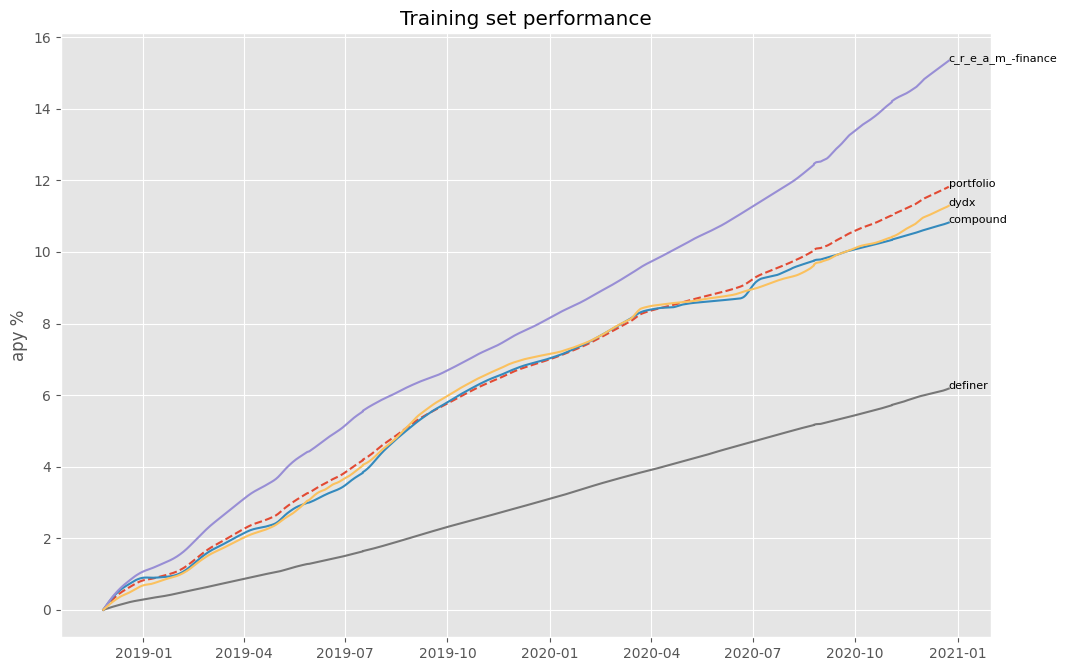

Expected annual return: 6.1%
Annual volatility: 0.1%
Sharpe Ratio: 32.71


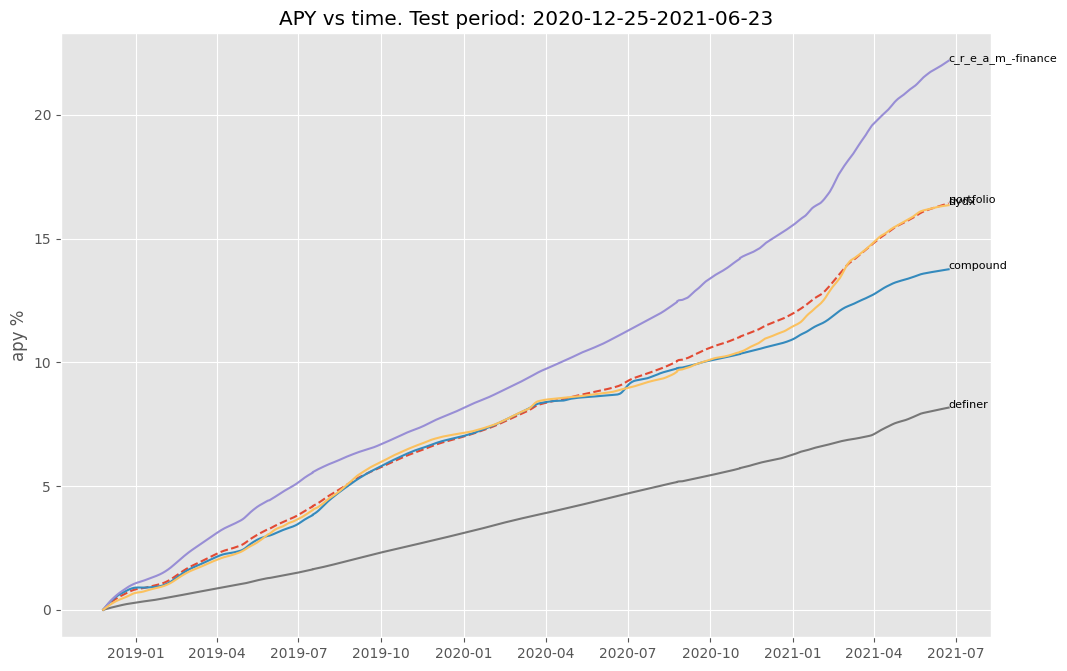

return in the test period 16.424838030894875


In [25]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import risk_matrix
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import plotting
from pypfopt.base_optimizer import portfolio_performance

def risk1_constraints(ef, train_df):
    for i in range(len(train_df.columns)):
        ef.add_constraint(lambda w: w[i] >= 0.1)
        ef.add_constraint(lambda w: w[i] <= 0.3)

risk1_weights, risk1_roi = optimize_portfolio(train_df, test_df, 
                                   rebalance_period=1, 
                                   target_volatility=0.05, 
                                   constraints_fn=risk1_constraints)

## BTC - ETH Portfolio

In [46]:
btceth_df = asset_prices_df.iloc[:,:2]
train_df = btceth_df[btceth_df.index < datetime.strptime(split_date, '%Y-%m-%d').date()]
test_df = btceth_df[(btceth_df.index >= datetime.strptime(test_start, '%Y-%m-%d').date()) 
                        & (btceth_df.index <= datetime.strptime(test_end, '%Y-%m-%d').date())]

btceth_df.tail()


,bitcoin,ethereum
2021-06-23,35426.368431,2168.788673
2021-06-24,34766.534594,2112.393415
2021-06-25,34263.938874,2056.583648
2021-06-26,33701.371031,1999.713483
2021-06-27,33193.132693,1948.390501


mean (yearly) return:
bitcoin     1.240378
ethereum    1.153180
dtype: float64

---portfolio weights---
OrderedDict([('bitcoin', 0.7), ('ethereum', 0.3)])


Expected annual return: 121.4%
Annual volatility: 27.8%
Sharpe Ratio: 4.30


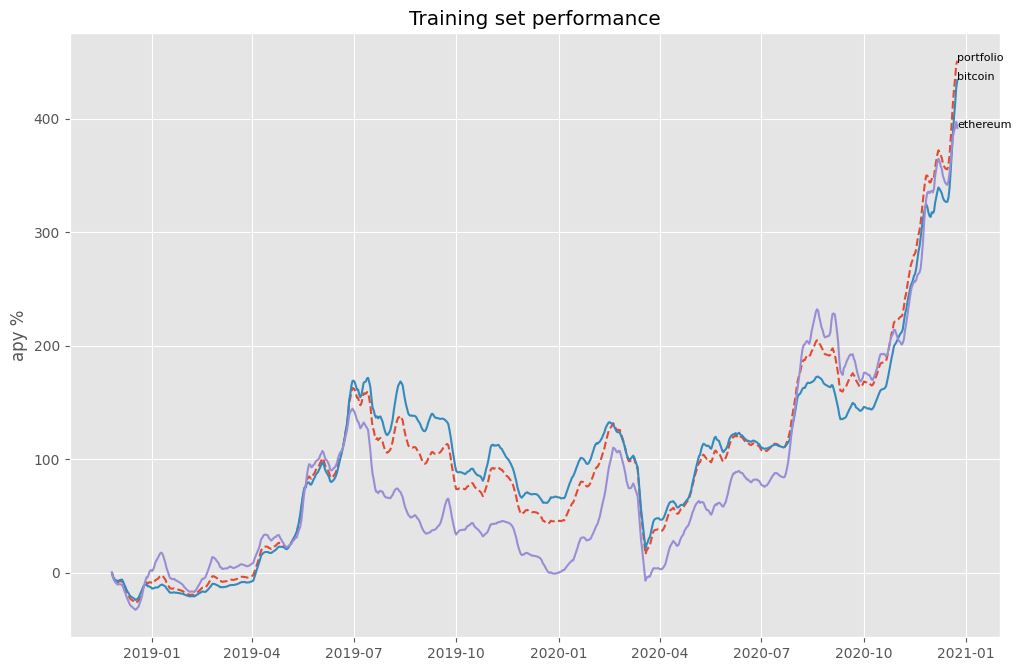

Expected annual return: 147.9%
Annual volatility: 29.8%
Sharpe Ratio: 4.89


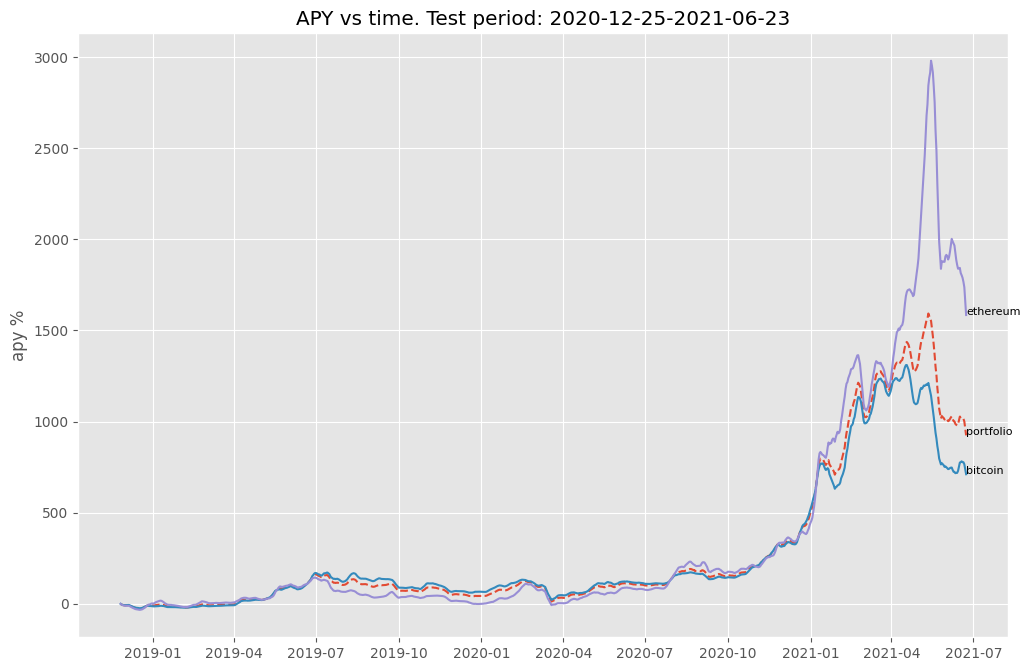

return in the test period 924.3274850977498


In [50]:
def risk2_constraints(ef, train_df):
    for i in range(len(train_df.columns)):
        ef.add_constraint(lambda w: w[i] >= 0.3)
#         ef.add_constraint(lambda w: w[i] <= 0.3)

risk2_weights, risk2_roi = optimize_portfolio(train_df, test_df, 
                                   rebalance_period=30, 
                                   target_volatility=0.3, 
                                   constraints_fn=risk2_constraints)

## Top 8 Alt Coins by Market Cap Portfolio

In [52]:
alt_coins_df = asset_prices_df.iloc[:,2:-6]
train_df = alt_coins_df[alt_coins_df.index < datetime.strptime(split_date, '%Y-%m-%d').date()]
test_df = alt_coins_df[(alt_coins_df.index >= datetime.strptime(test_start, '%Y-%m-%d').date()) 
                        & (alt_coins_df.index <= datetime.strptime(test_end, '%Y-%m-%d').date())]

alt_coins_df.tail()


,binancecoin,cardano,ripple,dogecoin,bitcoin-cash,litecoin,chainlink,ethereum-classic
2021-06-23,321.183987,1.363182,0.741132,0.263592,538.927971,148.842788,20.586150,48.952861
2021-06-24,313.996554,1.330144,0.713530,0.253521,521.799913,143.613450,19.918410,46.879381
2021-06-25,307.650977,1.311460,0.688783,0.247287,505.387619,138.948393,19.293317,45.091804
2021-06-26,300.000040,1.291143,0.663322,0.240169,490.521853,134.882230,18.709519,43.270930
2021-06-27,291.761390,1.270837,0.641930,0.233592,476.203831,130.970789,18.188745,41.694281


mean (yearly) return:
binancecoin         1.287459
cardano             0.839535
ripple              0.087830
dogecoin            0.322622
bitcoin-cash        0.209126
litecoin            0.786647
chainlink           4.767540
ethereum-classic    0.066992
dtype: float64

---portfolio weights---
OrderedDict([('binancecoin', 0.3),
             ('cardano', 0.15),
             ('ripple', 0.05),
             ('dogecoin', 0.05),
             ('bitcoin-cash', 0.05),
             ('litecoin', 0.05),
             ('chainlink', 0.3),
             ('ethereum-classic', 0.05)])


Expected annual return: 201.6%
Annual volatility: 32.5%
Sharpe Ratio: 6.15


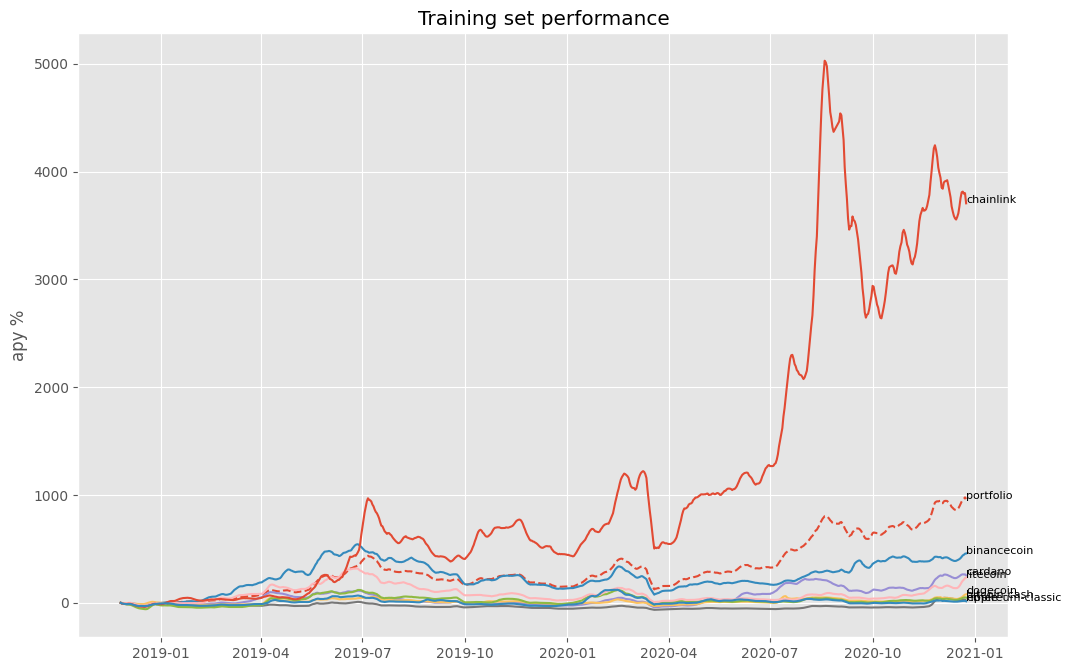

Expected annual return: 313.5%
Annual volatility: 37.1%
Sharpe Ratio: 8.39


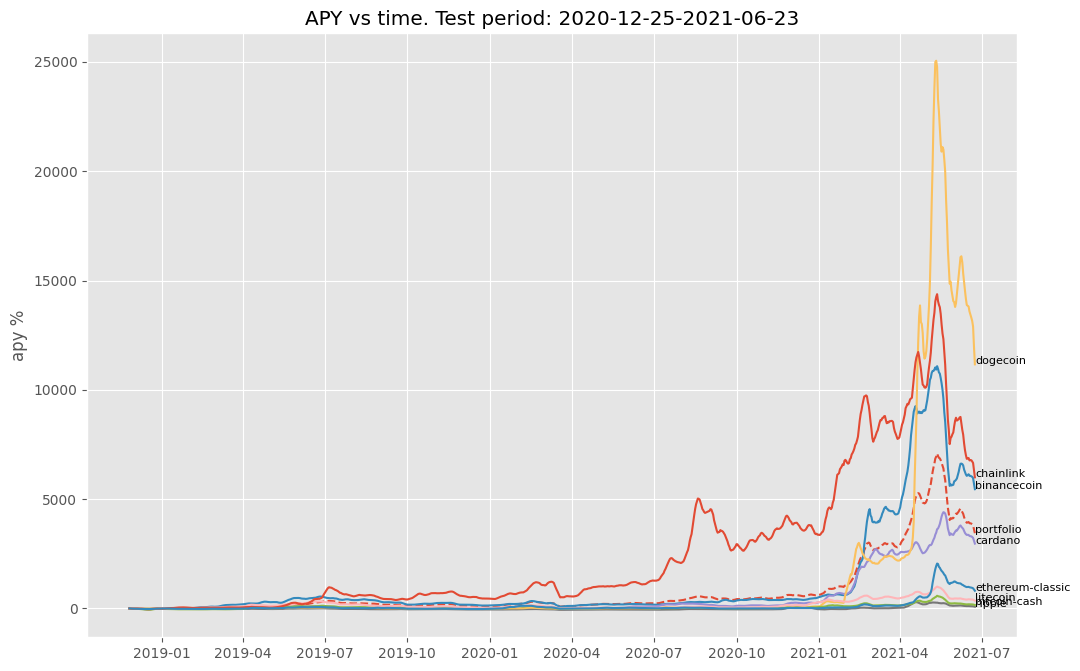

return in the test period 3441.435515998477


In [54]:
def risk3_constraints(ef, train_df):
    for i in range(len(train_df.columns)):
        ef.add_constraint(lambda w: w[i] >= 0.05)
        ef.add_constraint(lambda w: w[i] <= 0.3)

risk3_weights, risk3_roi = optimize_portfolio(train_df, test_df, 
                                   rebalance_period=30, 
                                   target_volatility=0.7, 
                                   constraints_fn=risk3_constraints)

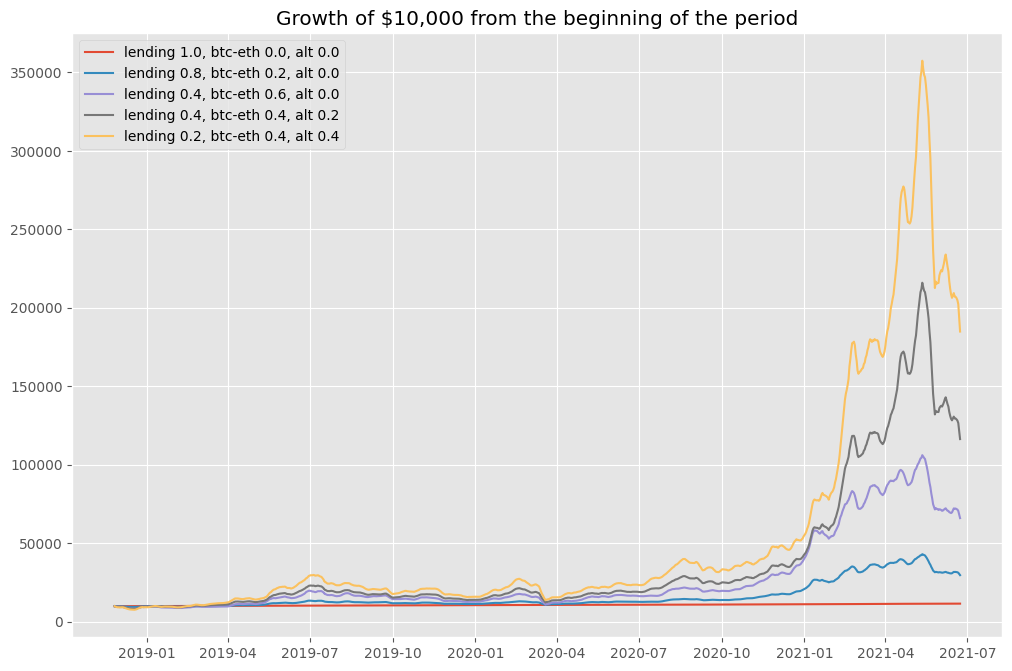

In [61]:
def mix_asset_portfolios(rois, allocations, init_investment=10000):
    portfolio_roi = sum([
        (1+np.array(roi)/100) * allocation * init_investment for roi, allocation in zip(rois, allocations)
    ])
    return portfolio_roi

rois = [risk1_roi, risk2_roi, risk3_roi]
portfolio_allocations = [[1., 0.0, 0.0],
                  [.80, 0.20, 0.0],
                  [.40, 0.60, 0.0],
                  [.40, 0.40, 0.20],
                  [.2, 0.4, 0.4]
                 ]
portfolio_rois = [mix_asset_portfolios(rois, alloc) for alloc in portfolio_allocations]

# print(len(test_df.index), len(risk1_roi))
for i, roi in enumerate(portfolio_rois):
    lending, btc_eth, alt = portfolio_allocations[i]
    plt.plot(test_df.index, roi, label=f"lending {lending}, btc-eth {btc_eth}, alt {alt}")
    plt.legend()
    plt.title("Growth of $10,000 from the beginning of the period")